In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision import transforms as T
# import torchutils as tu
from typing import Tuple
from tqdm import tqdm

from PIL import Image
import os
from torchvision import transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset
from PIL import Image


In [12]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [13]:
p = 'data/shabby-docs-denoise/train/train_cleaned'
len(os.listdir(p))

1269

In [14]:
preprocessing = T.Compose(
    [
        # T.ToPILImage(),
        T.Resize((400, 400)),
        # T.RandomRotation(10),
        T.ToTensor()
    ]
)

class CustomImageDataset(Dataset):
    def __init__(self, noise_dir, clean_dir, aug=None):
        self.noise_dir = noise_dir
        self.clean_dir = clean_dir

        self.noise_names = sorted(os.listdir(noise_dir))
        self.clean_names = sorted(os.listdir(clean_dir))

        self.aug = aug

    def __len__(self):
        return len(self.noise_names)

    def __getitem__(self, idx):
        noisy_img = Image.open((os.path.join(self.noise_dir, self.noise_names[idx])))
        clean_img = Image.open((os.path.join(self.clean_dir, self.clean_names[idx])))

        if self.aug:
            noisy_img = self.aug(noisy_img)
            clean_img = self.aug(clean_img)

        return noisy_img, clean_img

In [15]:
train_path_noise = 'data/shabby-docs-denoise/train/train_shabby'
train_path_clean = 'data/shabby-docs-denoise/train/train_cleaned'
train_set = CustomImageDataset(noise_dir=train_path_noise, clean_dir=train_path_clean, aug=preprocessing)

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
next(iter(train_loader))[1][0].shape

torch.Size([1, 400, 400])

In [16]:
class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 128, kernel_size=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, padding=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=4, padding=2),
            nn.LazyBatchNorm2d(),
            nn.Sigmoid()
        )

        self.layer1_t = nn.Sequential(
            nn.ConvTranspose2d(64, 256, kernel_size=4, padding=2),
            nn.LazyBatchNorm2d(),
            nn.SELU()
        )
        self.layer2_t = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, padding=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU()
        )
        self.layer3_t = nn.Sequential(
            nn.ConvTranspose2d(128, 16, kernel_size=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.Sigmoid()
        )
        self.layer4_t = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x


    def decode(self, x):
        x = self.layer1_t(x)
        x = self.layer2_t(x)
        x = self.layer3_t(x)
        x = self.layer4_t(x)
        return x

    def forward(self, x):
        latent = self.encode(x)
        out = self.decode(latent)
        return out


model = ConvEncoder().to(DEVICE)
# criterion = nn.BCELoss()
criterion = lambda x,y : torch.nn.functional.binary_cross_entropy(x,y) + torch.nn.functional.mse_loss(x,y) + torch.nn.functional.l1_loss(x,y)

x:\Development\VS Code\.venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [65]:
# import torchutils as tu

# model.to(DEVICE)
# tu.get_model_summary(model, torch.randn(8, 1, 400, 400, device=DEVICE))

In [17]:
def denoiser_train(
        model: torch.nn.Module,
        epoch: int,
        optimizer: torch.nn.Module
) -> list:
    
    model.to(DEVICE)

    epoch_loss = []
    model.train()

    
    for i in tqdm(range(epoch)):
        batch_loss = []

        for noise, clean in tqdm(train_loader):
            out = model(noise.to(DEVICE))
            loss = criterion(out, clean.to(DEVICE))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

        epoch_loss.append(np.mean(batch_loss))

    return epoch_loss

100%|██████████| 6/6 [18:24<00:00, 184.04s/it]


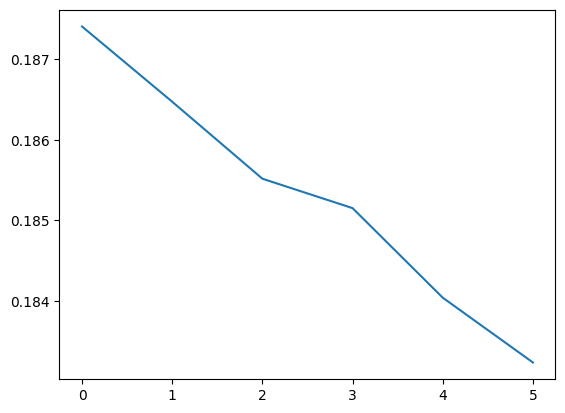

In [108]:
optimizer = optim.Adam(model.parameters())
losses = denoiser_train(model, 6, optimizer)
plt.plot(losses)

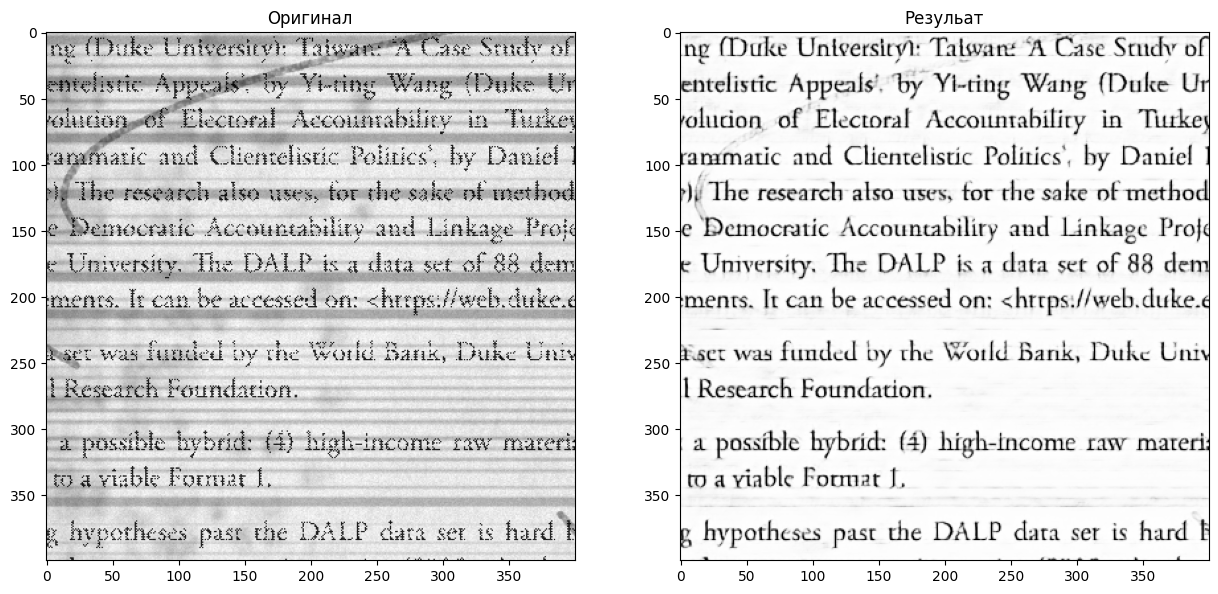

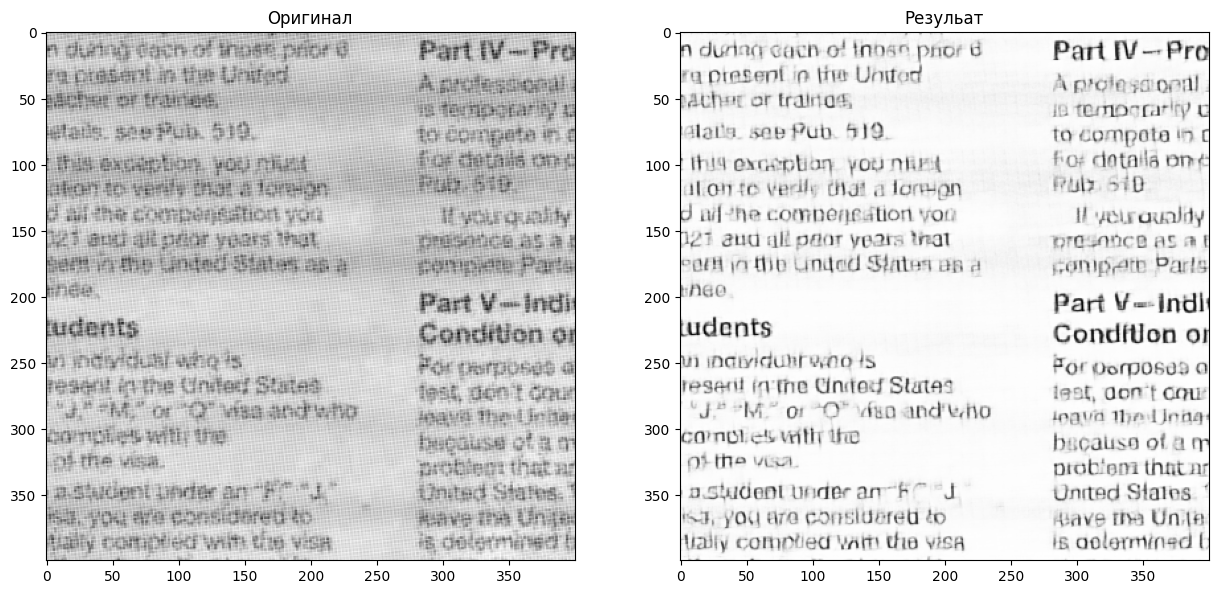

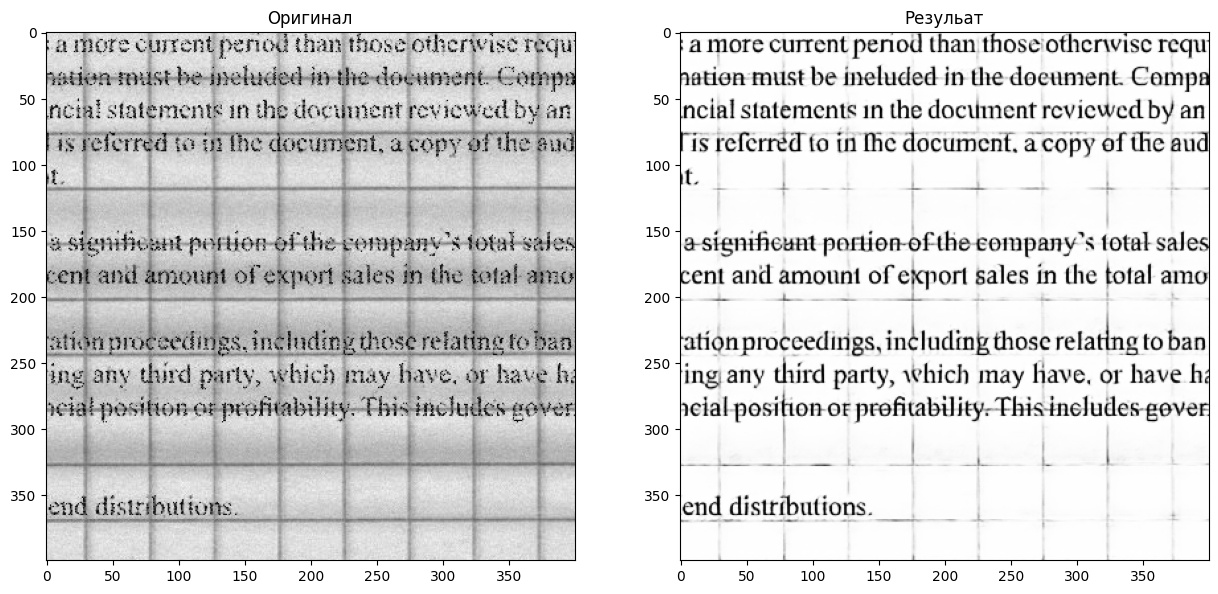

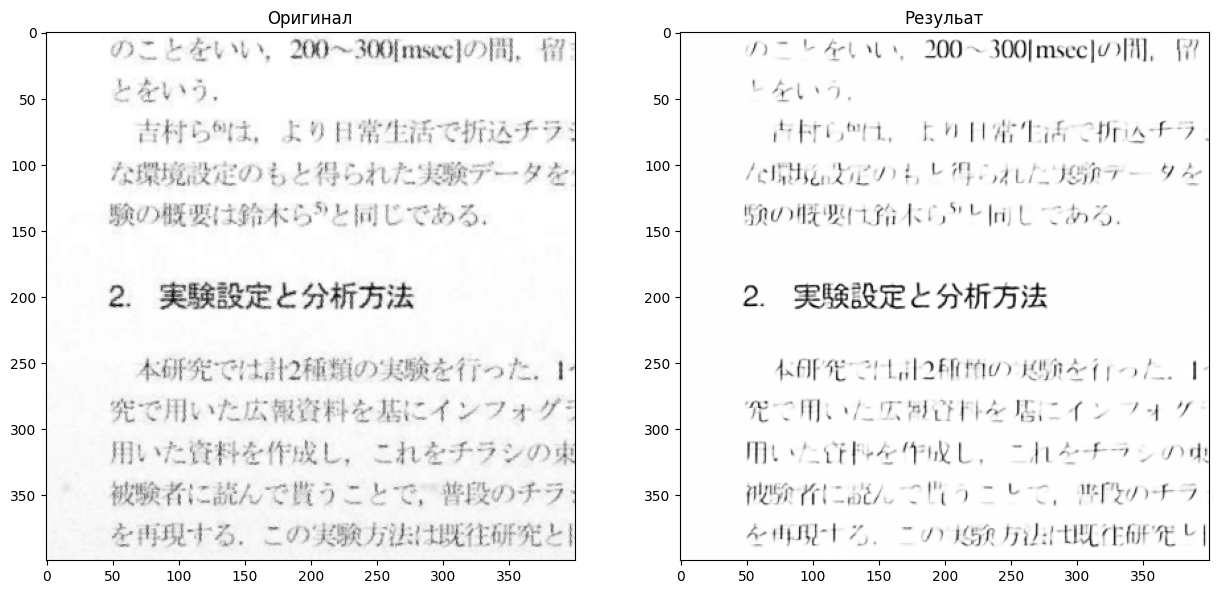

In [111]:


name = '0565-IDEA-Politics_Meets_Policies.pdf-085.png'

name = '0033-IRS-irs-pdf_p5087fs.pdf-25.png'
'0599-SEC-Form_20_F.pdf-21.png'
'0514-JSCE_52-05.pdf-2.png'

names = ['0565-IDEA-Politics_Meets_Policies.pdf-085.png','0033-IRS-irs-pdf_p5087fs.pdf-25.png','0599-SEC-Form_20_F.pdf-21.png','0514-JSCE_52-05.pdf-2.png']

for name in names:
    path = 'data/shabby-docs-denoise/test/test_cleaned/' + name
    path2 = 'data/shabby-docs-denoise/test/test_shabby/' + name

    img = Image.open(path)
    img2 = Image.open(path2)

    x = preprocessing(img2).unsqueeze(0)


    model.to('cpu')
    model.eval()
    img3 = T.ToPILImage()(model(x).squeeze().detach())





    f, axs = plt.subplots(1, 2, figsize=(15, 15))
    # plt.subplot(1,2,1)
    # plt.title('Эталон')
    # plt.imshow(img, cmap='gray')

    plt.subplot(1,2,1)
    plt.title('Оригинал')
    plt.imshow(img2, cmap='gray')

    plt.subplot(1,2,2)
    plt.title('Резульат')
    plt.imshow(img3, cmap='gray')

In [23]:
test_path_noise = 'data/shabby-docs-denoise/test/test_shabby'
test_path_clean = 'data/shabby-docs-denoise/test/test_cleaned'
test_set = CustomImageDataset(noise_dir=test_path_noise, clean_dir=test_path_clean, aug=preprocessing)

test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

RMSE = []

for noise, clean in tqdm(test_loader):

    model.to(DEVICE)
    noise.cuda()
    clean.cuda()

    model.eval()
    with torch.no_grad():
        pred = model(noise.cuda())

    x = (torch.nn.functional.mse_loss(pred.cuda(), clean.cuda())).cpu()
    RMSE.append(x)

RMSE = np.array(RMSE)

100%|██████████| 186/186 [00:11<00:00, 15.68it/s]


In [114]:
RMSE.mean()

0.014091942

In [115]:
torch.save(model.state_dict(), 'weights.pt')